# <center>Reinforcement Learning</center>
<center><h1 style="color:blue">Actor-Critic</h1></center>

# Solving Complex Environments

## ENVIRONMENT 2 - Grid World

In [8]:
import gym as gym
import gym
from gym import spaces
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage,AnnotationBbox
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical


In [5]:
class FrozenLakeEnv(gym.Env):
    metadata={'render.modes': []}
    
    def __init__(self,gma=0.9,alpha=0.1,max_timestamp=10):
        self.gma=gma
        self.alpha=alpha

        self.obs_space=spaces.Discrete(16)
        self.action_space=spaces.Discrete(4)
        self.observation_space=spaces.Box(low=0,high=1,shape=(16,),dtype=np.float32)
        self.max_timestamp=max_timestamp
        self.timestep=0

        ## STATES SET #############
        self.state=np.zeros((4,4))
        self.myskater=np.asarray([0,0])
        self.goal_loc=np.asarray([3,3])
        self.gem_loc=[np.asarray([0,2]),np.asarray([3,2])]
        self.hole_loc=[np.asarray([1,3]),np.asarray([2,0])]

        self.state[tuple(self.myskater)]=0.2
        self.state[tuple(self.goal_loc)]=0.8
        for pos in self.gem_loc:
            self.state[tuple(pos)]=0.5
        for pos in self.hole_loc:
            self.state[tuple(pos)]=0.4
        ##########################

        self.prev_state=np.zeros((4,4))
        self.prev_action=None
        self.penalty_counter=0  
        self.flag_out_grid=0  

    def step(self,act):
        self.prev_state=np.copy(self.state)  
        self.prev_action=act  
        self.flag_out_grid=0  

        ## ACTIONS SET #############
        if act == 0:    # moves right
            self.myskater[0] += 1
        elif act == 1:   # moves left
            self.myskater[0] -= 1
        elif act == 2:   # moves up
            self.myskater[1] += 1 
        elif act == 3:    # moves down
            self.myskater[1] -= 1
        ##########################
            
        self.myskater=np.clip(self.myskater,0,3)

        # If the agent is in the same position as the previous step,choose a different act
        prev_state_positions=np.argwhere(self.prev_state == 0.2)
        if len(prev_state_positions) > 0 and np.array_equal(self.myskater,prev_state_positions[0]):
            while act == self.prev_action:
                act=self.action_space.sample()
            self.flag_out_grid=1

        self.state=np.zeros((4,4))
        self.state[tuple(self.myskater)]=0.2
        self.state[tuple(self.goal_loc)]=0.8
        for pos in self.gem_loc:
            self.state[tuple(pos)]=0.5
        for pos in self.hole_loc:
            self.state[tuple(pos)]=0.4

        obs=self.state.flatten()
        rwd=self.calculate_reward()
        penalty=any(np.array_equal(self.myskater,pos) for pos in self.hole_loc)
        if penalty:
            self.penalty_counter += 1 
        self.timestep += 1

        terminated=True if np.array_equal(self.myskater,self.goal_loc) else self.timestep >= self.max_timestamp
        truncated=True if np.any((self.myskater < 0) | (self.myskater > 3)) else False
        if truncated:
            self.flag_out_grid=1  

        info={}

        return self.state.flatten(),rwd,terminated,info

    def reset(self,**kwargs):
        self.state=np.zeros((4,4))
        self.myskater=np.asarray([0,0])
        self.state[tuple(self.myskater)]=0.2
        self.state[tuple(self.goal_loc)]=0.8

        for pos in self.gem_loc:
            self.state[tuple(pos)]=0.5
        for pos in self.hole_loc:
            self.state[tuple(pos)]=0.4

        self.prev_state=np.zeros((4,4))
        self.prev_action=None
        self.flag_out_grid=0 
        
        obs=self.state.flatten()
        self.timestep=0
        info={}
        self.penalty_counter=0
        return obs

    def calculate_reward(self):
        prev_myskateritions=np.argwhere(self.prev_state == 0.2)
        if prev_myskateritions.size == 0:
            prev_myskaterition=self.myskater
        else:
            prev_myskaterition=prev_myskateritions[0]

        # Calculating distance to goal before and after the step
        prev_distance_to_goal=np.linalg.norm(self.goal_loc-prev_myskaterition)
        current_distance_to_goal=np.linalg.norm(self.goal_loc-self.myskater)

        ## REWARDS SET #############
        if np.array_equal(self.myskater,self.goal_loc):
            rwd=17  # Positive rwd for reaching goal
        elif np.array_equal(self.myskater,self.hole_loc[0]):
            rwd=-5  # negative rwd for reaching holes 1
        elif np.array_equal(self.myskater,self.hole_loc[1]):
            rwd=-6   # negative rwd for reaching holes 2
        elif np.array_equal(self.myskater,self.gem_loc[0]):
            rwd=5   # positive rwd for reaching gems 1
        elif np.array_equal(self.myskater,self.gem_loc[1]):
            rwd=6  # positive rwd for reaching gems 2
        elif current_distance_to_goal < prev_distance_to_goal:
            rwd=1  # Positive rwd for moving closer to goal
        elif current_distance_to_goal > prev_distance_to_goal:
            rwd=-1  # Negative rwd for moving away to goal
        else:
            rwd=-0.1  # Slight negative rwd for no change
        ##########################
        
        return rwd
    
    def get_penalty_count(self):
        return self.penalty_counter

    def render(self):
        fig,ax=plt.subplots()
        plt.title('Frozen Lake Environment')

        # Load and display the background image
        background_img=plt.imread('Images/frozen_lake.jpg')
        ax.imshow(background_img,extent=(-0.5,3.5,-0.5,3.5),origin='upper')

       
        skater_img=plt.imread('Images/icons8-skateboard-100.png')
        hole_img=plt.imread('Images/icons8-hole-100.png')
        gem_img=plt.imread('Images/icons8-gems-100.png')
        goal_img=plt.imread('Images/icons8-flag-100.png')
        skater_hole_drown_img=plt.imread('Images/agent_hole_drown.png')
        skater_gem_lottery_img=plt.imread('Images/agent_gems_lottery.png')
        agent_flag_winner_img=plt.imread('Images/agent_flag_winner.png')
        agent_grid_cross_img=plt.imread('Images/agent_grid_cross.png')

        # Plot Skater
        myskater=self.myskater
        if self.flag_out_grid:
            skater_img=agent_grid_cross_img
        agent_box=AnnotationBbox(OffsetImage(skater_img,zoom=0.4),myskater,frameon=False)
        ax.add_artist(agent_box)

        # Plot Holes
        for hole_loc in self.hole_loc:
            hole_loc=hole_loc
            if np.array_equal(self.myskater,hole_loc):
                hole_img=skater_hole_drown_img
            else:
                hole_img=plt.imread('Images/icons8-hole-100.png')
            rock_box=AnnotationBbox(OffsetImage(hole_img,zoom=0.4),hole_loc,frameon=False)
            ax.add_artist(rock_box)

        # Plot Gems
        for gem_loc in self.gem_loc:
            gem_loc=gem_loc
            if np.array_equal(self.myskater,gem_loc):
                gem_img=skater_gem_lottery_img
            else:
                gem_img=plt.imread('Images/icons8-gems-100.png')
            battery_box=AnnotationBbox(OffsetImage(gem_img,zoom=0.4),gem_loc,frameon=False)
            ax.add_artist(battery_box)

        # Plot goal
        goal_loc=self.goal_loc
        goal_loc=self.goal_loc
        if np.array_equal(self.myskater,goal_loc):
            goal_img=agent_flag_winner_img
        else:
            goal_img=plt.imread('Images/icons8-flag-100.png')
        goal_box=AnnotationBbox(OffsetImage(goal_img,zoom=0.4),goal_loc,frameon=False)
        ax.add_artist(goal_box)

        plt.xticks(np.arange(-0.5,4.5,1))
        plt.yticks(np.arange(-0.5,4.5,1))
        plt.gca().set_xticklabels(np.arange(-0.5,4.5,1))
        plt.gca().set_yticklabels(np.arange(-0.5,4.5,1))
        plt.show()

    def obs_space_to_index(self,obs):
        """ Convert the agent's position to an integer index for the Q-table. """
        myskater=np.argwhere(obs.reshape(4,4) == 0.2)
        if myskater.size == 0:
            return 0 
        return myskater[0,0]*4+myskater[0,1]


Step 1 - Action: 1, Reward: -0.1
Current State:
[[0.2 0.  0.5 0. ]
 [0.  0.  0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


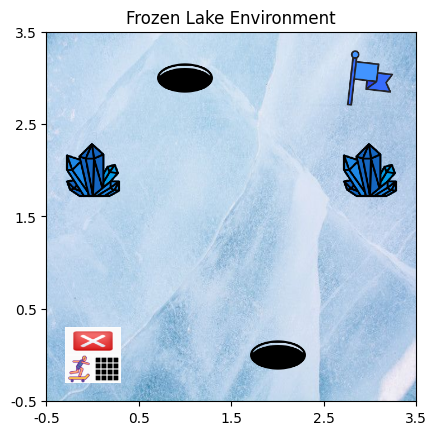

Step 2 - Action: 0, Reward: 1
Current State:
[[0.  0.  0.5 0. ]
 [0.2 0.  0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


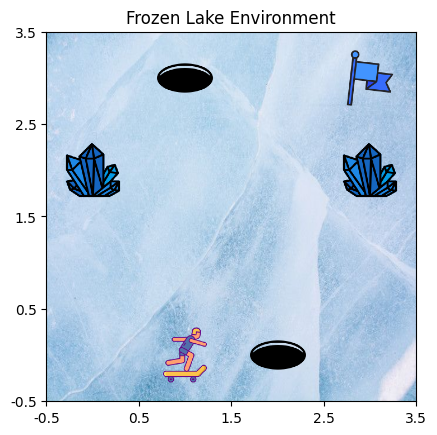

Step 3 - Action: 3, Reward: -0.1
Current State:
[[0.  0.  0.5 0. ]
 [0.2 0.  0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


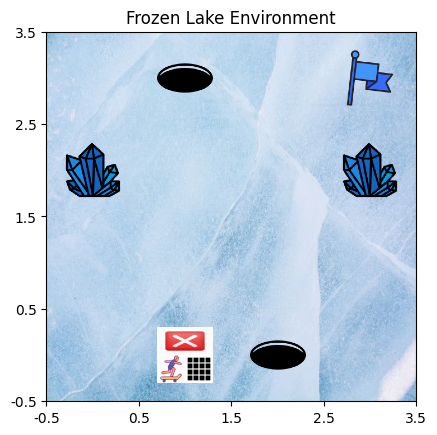

Step 4 - Action: 3, Reward: -0.1
Current State:
[[0.  0.  0.5 0. ]
 [0.2 0.  0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


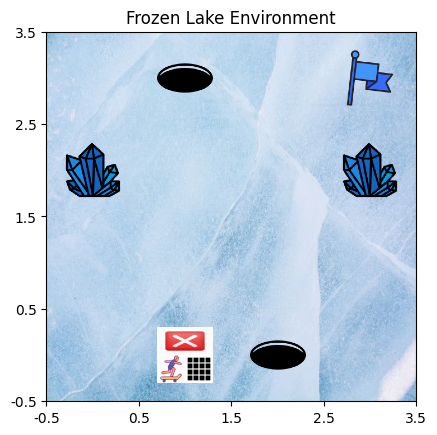

Step 5 - Action: 0, Reward: -6
Current State:
[[0.  0.  0.5 0. ]
 [0.  0.  0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


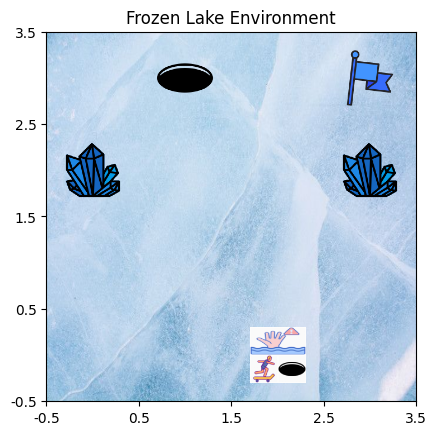

Step 6 - Action: 1, Reward: -0.1
Current State:
[[0.  0.  0.5 0. ]
 [0.2 0.  0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


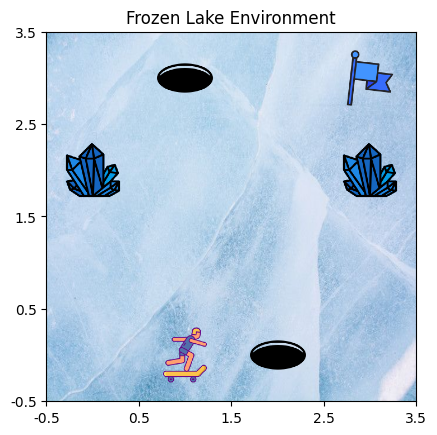

Step 7 - Action: 1, Reward: -1
Current State:
[[0.2 0.  0.5 0. ]
 [0.  0.  0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


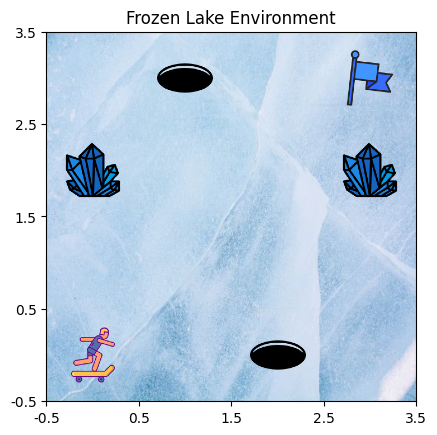

Step 8 - Action: 0, Reward: 1
Current State:
[[0.  0.  0.5 0. ]
 [0.2 0.  0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


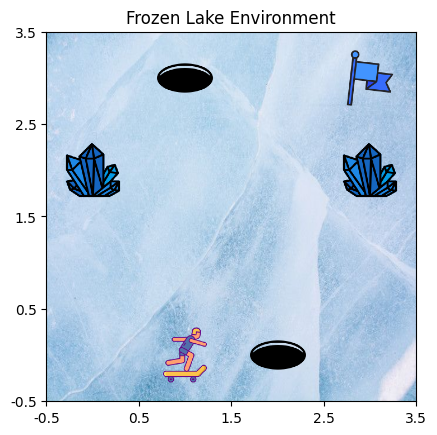

Step 9 - Action: 2, Reward: 1
Current State:
[[0.  0.  0.5 0. ]
 [0.  0.2 0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


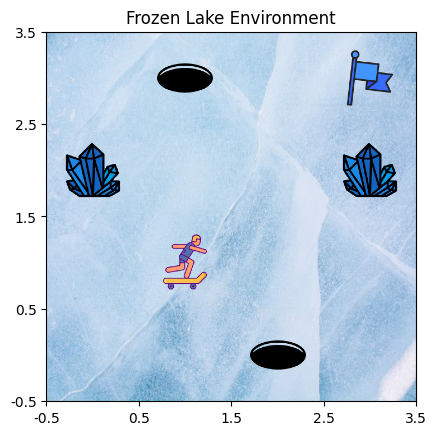

Step 10 - Action: 0, Reward: 1
Current State:
[[0.  0.  0.5 0. ]
 [0.  0.  0.  0.4]
 [0.4 0.2 0.  0. ]
 [0.  0.  0.5 0.8]]


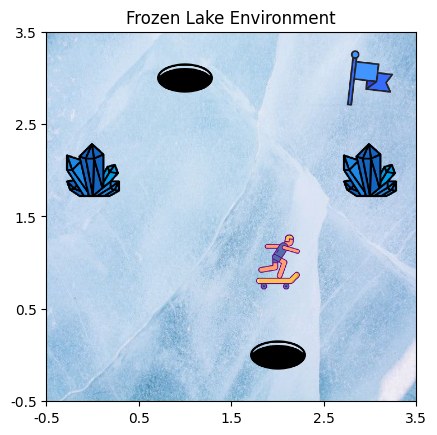

In [6]:
env_det=FrozenLakeEnv()
for _ in range(10):
    act=env_det.action_space.sample()
    obs,rwd,done,info=env_det.step(act)
    print(f"Step {_+1}-Action: {act},Reward: {rwd}")
    print("Current State:")
    print(env_det.state)
    env_det.render()

    if done:
        env_det.state=np.copy(env_det.prev_state) 
        env_det.myagent=np.argwhere(env_det.state == 0.2)[0]

In [9]:
class AC(nn.Module):
    def __init__(self,inp_dim,out_dim,hid_dim=64):
        super(AC,self).__init__()
        self.actor=nn.Sequential(
            nn.Linear(inp_dim,hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim,out_dim),
            nn.Softmax(dim=-1)
        )
        self.critic=nn.Sequential(
            nn.Linear(inp_dim,hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim,1)
        )
    def forward(self,x):
        return self.actor(x),self.critic(x)

In [10]:
class A2CAgent:
    def __init__(self,env,lr=0.02,gma=0.99):
        self.env=env
        self.obs_dim=env.observation_space.shape[0]
        self.act_dim=env.action_space.n
        self.lr=lr
        self.gma=gma
        self.model=AC(self.obs_dim,self.act_dim)
        self.optimizer=optim.Adam(self.model.parameters(),lr=self.lr)

    def compute_returns(self,rwds):
        returns=[]
        R=0
        for r in reversed(rwds):
            R=r+self.gma*R
            returns.insert(0,R)
        return returns

    def train(self,max_epi=1000,max_stp=100):
        epi_rwds=[]
        for epi in range(max_epi):
            obs=self.env.reset()
            done=False
            tot_rwd=0
            probs=[]
            values=[]
            rwds=[]
            for _ in range(max_stp):
                obs_tensor=torch.FloatTensor(obs).unsqueeze(0)
                act_probs,value=self.model(obs_tensor)
                act_dist=Categorical(act_probs)
                act=act_dist.sample()
                obs,rwd,done,_=self.env.step(act.item())
                probs.append(act_dist.log_prob(act))
                values.append(value)
                rwds.append(rwd)
                tot_rwd += rwd
                if done:
                    break
            epi_rwds.append(tot_rwd)
            returns=self.compute_returns(rwds)
            probs=torch.cat(probs)
            values=torch.cat(values)
            returns=torch.tensor(returns)
            advantage=returns-values
            actor_loss=-(probs*advantage.detach()).mean()
            critic_loss=nn.MSELoss()(values,returns)
            total_loss=actor_loss+critic_loss
            self.optimizer.zero_grad()
            total_loss.backward()
            self.optimizer.step()
            print(f"Episode {epi+1},Total Reward: {tot_rwd}")
        return epi_rwds
    
    def act_greedy(self,obs):
        obs_tensor=torch.FloatTensor(obs).unsqueeze(0)
        act_probs,_=self.model(obs_tensor)
        act=torch.argmax(act_probs,dim=-1)
        return act.item()

    def evaluation_work(self,max_epi=1000,max_stp=100):
        epi_rwds=[]
        for _ in range(max_epi):
            obs=self.env.reset()
            done=False
            tot_rwd=0
            rwds=[]
            for _ in range(max_stp):
                act=self.act_greedy(obs)
                obs,rwd,done,_=self.env.step(act)
                rwds.append(rwd)
                tot_rwd += rwd
                if done:
                    break
            epi_rwds.append(tot_rwd)
        return epi_rwds

In [ ]:
env=FrozenLakeEnv()
agent=A2CAgent(env)
epi_rwds=agent.train()

Episode 1, Total Reward: -9.10
Episode 2, Total Reward: 5.60
Episode 3, Total Reward: 5.40
Episode 4, Total Reward: 5.40
Episode 5, Total Reward: -7.30
Episode 6, Total Reward: 5.20
Episode 7, Total Reward: -14.20
Episode 8, Total Reward: 20.50
Episode 9, Total Reward: 0.50
Episode 10, Total Reward: 0.10
Episode 11, Total Reward: -0.80
Episode 12, Total Reward: 25.60
Episode 13, Total Reward: 35.80
Episode 14, Total Reward: 0.10
Episode 15, Total Reward: 20.50
Episode 16, Total Reward: 10.30
Episode 17, Total Reward: 30.70
Episode 18, Total Reward: 35.80
Episode 19, Total Reward: 25.60
Episode 20, Total Reward: 30.70
Episode 21, Total Reward: 0.30
Episode 22, Total Reward: 10.30
Episode 23, Total Reward: 5.20
Episode 24, Total Reward: 25.60
Episode 25, Total Reward: 10.30
Episode 26, Total Reward: 10.30
Episode 27, Total Reward: 0.10
Episode 28, Total Reward: 20.50
Episode 29, Total Reward: 10.30
Episode 30, Total Reward: 5.20
Episode 31, Total Reward: -1.00
Episode 32, Total Reward: 2

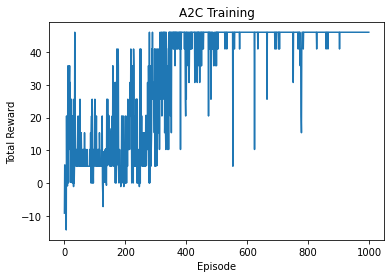

In [ ]:
plt.plot(epi_rwds)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('A2C Training')
plt.show()

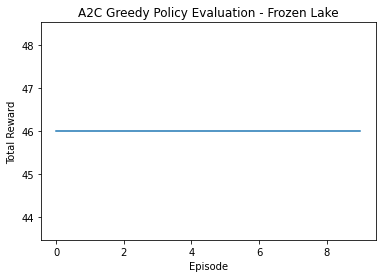

In [59]:
episode_rewards_frozen_lake=agent.evaluation_work(max_epi=10)
plt.plot(episode_rewards_frozen_lake)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('A2C Greedy Policy Evaluation-Frozen Lake')
plt.show()

In [60]:
torch.save(agent.model.state_dict(),'part2_env2_grid_world_model.pth')

## REFERENCE:

- **Assignment 3, Defining and Solving Reinforcement Learning Task, FALL 2023: Intro to ML, Team: Charvi Kusuma, Tarun reddi**
- **Assignment 1, Defining & Solving RL Environments, SPR 2024: CSE 546: Reinforcement Learning: Charvi Kusuma**